<a href="https://colab.research.google.com/github/HAR5HA-7663/MCS-5993-Evolutionary-Computation-and-Deep-Learning/blob/main/Assignments/4/XOR3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## XOR with 3 classes

<pre>
   | x0 | x1 |XOR3|
   |----|----|----|
   |0.0 |0.0 | 0  |
   |0.0 |1.0 | 1  |
   |1.0 |0.0 | 1  |
   |1.0 |1.0 | 0  |
   |0.5 |0.5 | 2  |
</pre>

In [27]:
import numpy as np
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras import optimizers

# the five different states of the XOR3 gate
X = np.array([[0,0],[0,1],[1,0],[1,1],[0.5,0.5],[0.6,0.6]])

# the five expected results in the same order
y = np.array([[0],[1],[1],[0],[2],[2]])

Xt = np.array([[0,0.1],[0.1,1],[0.9,0],[0.9,1],[0.55,0.45]])
yt = np.array([[0],[1],[1],[0],[2]])

In [28]:
act_func = ('relu', 'elu', 'sigmoid', 'tanh', 'leaky_relu')
optimz = ('SGD', 'RMSprop', 'Adam')
loss_func = 'sparse_categorical_crossentropy'

print("Activation functions:", act_func)
print("Optimizers:", optimz)
print("Loss function:", loss_func)

Activation functions: ('relu', 'elu', 'sigmoid', 'tanh', 'leaky_relu')
Optimizers: ('SGD', 'RMSprop', 'Adam')
Loss function: sparse_categorical_crossentropy


In [29]:
# Using 'sparse_categorical_crossentropy'
def XOR3_eval(param):
    """
    param indices:
      0: num of hidden neurons
      1: learning rate
      2: batch size
      3: activation function index
      4: loss function index (fixed, not really used)
      5: optimizer index
    """
    global model
    model = Sequential([
        keras.Input(shape=(2,)),
        Dense(int(param[0]), activation=act_func[round(param[3])]),
        Dense(3, activation='softmax')
    ])

    if round(param[5]) == 0:
        optmzr = optimizers.SGD(learning_rate=param[1])
    elif round(param[5]) == 1:
        optmzr = optimizers.RMSprop(learning_rate=param[1])
    else:
        optmzr = optimizers.Adam(learning_rate=param[1])

    model.compile(
    optimizer=optmzr,
    loss=loss_func, # target labels are integers
    metrics=['accuracy']
    )
    model.fit(X, y, batch_size=int(param[2]), epochs=int(param[4]), verbose=0)

    loss, acc = model.evaluate(Xt, yt, verbose=0)
    return loss

# test_param = [4, 0.5, 2, 2, 0, 1]  # neurons, lr, bsize, act='sigmoid', loss, opt='RMSprop'
# print("loss =", XOR3_eval(test_param))

In [30]:
def print_HP_found(x, eval):
    print(
        f"#neurons={int(x[0])}, "
        f"lr={x[1]:.3f}, "
        f"bsize={int(x[2])}, "
        f"actF={act_func[int(round(x[3]))]}, "
        f"epochs={int(x[4])}, "
        f"optim={optimz[int(round(x[5]))]}, "
        f"Eval={eval:.6f}"
    )

In [31]:
import matplotlib.pyplot as plt
import numpy as np
from keras.models import load_model

def plot_XOR3_decision_boundary(model=None, model_path=None, title="Decision Boundary for XOR3"):
    # Load from file if a path is given
    if model is None and model_path is not None:
        model = load_model(model_path)

    # Extract training samples for plotting
    xpoint = X[:, 0]
    ypoint = X[:, 1]
    print("xpoints:", xpoint)
    print("ypoints:", ypoint)

    # Prepare storage for predicted class coordinates
    xp_cls0, yp_cls0 = np.array([]), np.array([])
    xp_cls1, yp_cls1 = np.array([]), np.array([])
    xp_cls2, yp_cls2 = np.array([]), np.array([])
    num0 = num1 = num2 = 0

    # Scan 2D grid [0,1]×[0,1]
    for x in np.arange(0.0, 1.02, 0.02):
        for y in np.arange(0.0, 1.02, 0.02):
            xy = np.array([[x, y]], dtype=np.float32)
            pred = np.argmax(model.predict(xy, verbose=0))
            if pred == 0:
                xp_cls0 = np.append(xp_cls0, x)
                yp_cls0 = np.append(yp_cls0, y)
                num0 += 1
            elif pred == 1:
                xp_cls1 = np.append(xp_cls1, x)
                yp_cls1 = np.append(yp_cls1, y)
                num1 += 1
            else:
                xp_cls2 = np.append(xp_cls2, x)
                yp_cls2 = np.append(yp_cls2, y)
                num2 += 1

    # --- Plot the decision regions ---
    plt.figure(figsize=(6, 5))
    plt.plot(xpoint, ypoint, 'ks', label='Training samples')
    plt.plot(xp_cls0, yp_cls0, 'b.', label='Class 0')
    plt.plot(xp_cls1, yp_cls1, 'r*', label='Class 1')
    plt.plot(xp_cls2, yp_cls2, 'g+', label='Class 2')
    plt.title(title)
    plt.xlabel("x₀")
    plt.ylabel("x₁")
    plt.legend()
    plt.show()

    # --- Print class percentages ---
    total = num0 + num1 + num2
    print(f"Class-0 (blue) % = {num0/total*100:.2f}")
    print(f"Class-1 (red)  % = {num1/total*100:.2f}")
    print(f"Class-2 (green)% = {num2/total*100:.2f}")

In [ ]:
def format_time(seconds):
    """Return time in 'hh hrs mm mins ss secs' format."""
    seconds = int(seconds)
    hrs, rem = divmod(seconds, 3600)
    mins, secs = divmod(rem, 60)
    parts = []
    if hrs > 0:
        parts.append(f"{hrs} hr{'s' if hrs>1 else ''}")
    if mins > 0:
        parts.append(f"{mins} min{'s' if mins>1 else ''}")
    if secs > 0 or not parts:
        parts.append(f"{secs} sec{'s' if secs!=1 else ''}")
    return " ".join(parts)

[#neurons, lr, bsize, actfun, lossfun, optmzr]

************************** Trial # = 1
Trial 1: Initializing hyperparameters
Trial 1: Evaluating parent
Trial 1: Parent value: 2.332059621810913
Trial 1: Starting evolution loop
Trial 1, Gen 1: Starting generation
Trial 1, Gen 1: Mutating hyperparameters
Trial 1, Gen 1: Offspring: [  2.           1.5          4.09484654   4.         402.31199377
   0.        ]
Trial 1, Gen 1: Evaluating offspring
Trial 1, Gen 1: Offspring value: 0.69920814037323
Trial 1, Gen 1: Offspring accepted, new parent value: 0.69920814037323
Trial 1, Gen 2: Starting generation
Trial 1, Gen 2: Mutating hyperparameters
Trial 1, Gen 2: Offspring: [4.70103576e+00 1.43000000e+00 3.86431936e+00 2.06116195e-01
 5.00000000e+02 4.83264292e-01]
Trial 1, Gen 2: Evaluating offspring
Trial 1, Gen 2: Offspring value: 0.8823505640029907
Trial 1, Gen 2: Offspring rejected
Trial 1, Gen 3: Starting generation
Trial 1, Gen 3: Mutating hyperparameters
Trial 1, Gen 3: Offspring: [ 11.3

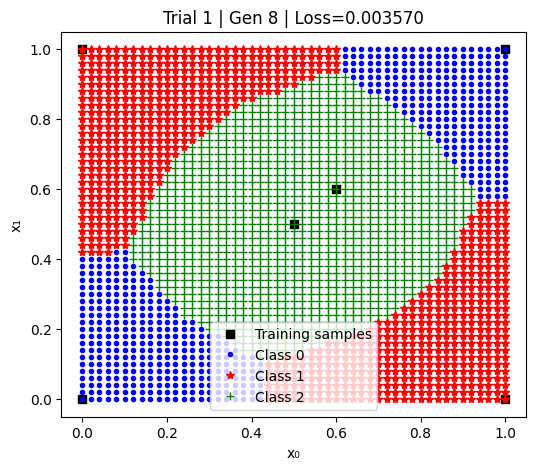

Class-0 (blue) % = 22.61
Class-1 (red)  % = 34.41
Class-2 (green)% = 42.98
Trial 1: Trial completed

************************** Trial # = 2
Trial 2: Initializing hyperparameters
Trial 2: Evaluating parent
Trial 2: Parent value: 1.428760290145874
Trial 2: Starting evolution loop
Trial 2, Gen 1: Starting generation
Trial 2, Gen 1: Mutating hyperparameters
Trial 2, Gen 1: Offspring: [8.57207943e+00 1.00000000e-02 4.61102120e+00 1.55048926e+00
 1.00000000e+02 0.00000000e+00]
Trial 2, Gen 1: Evaluating offspring
Trial 2, Gen 1: Offspring value: 1.1019816398620605
Trial 2, Gen 1: Offspring accepted, new parent value: 1.1019816398620605
Trial 2, Gen 2: Starting generation
Trial 2, Gen 2: Mutating hyperparameters
Trial 2, Gen 2: Offspring: [2.00000000e+00 4.00000000e-02 4.47795051e+00 0.00000000e+00
 1.00000000e+02 0.00000000e+00]
Trial 2, Gen 2: Evaluating offspring
Trial 2, Gen 2: Offspring value: 1.024641513824463
Trial 2, Gen 2: Offspring accepted, new parent value: 1.024641513824463
Trial

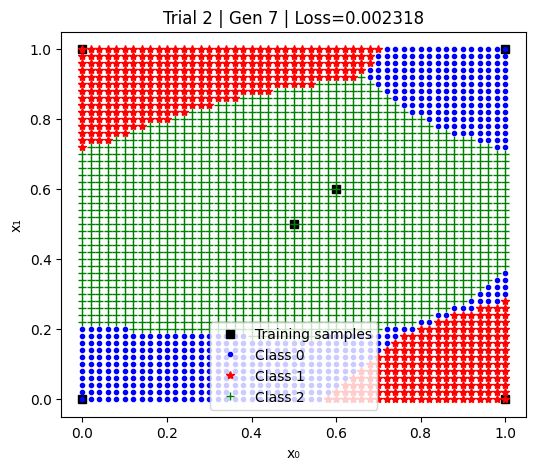

Class-0 (blue) % = 20.76
Class-1 (red)  % = 19.57
Class-2 (green)% = 59.67
Trial 2: Trial completed

************************** Trial # = 3
Trial 3: Initializing hyperparameters
Trial 3: Evaluating parent
Trial 3: Parent value: 0.540442943572998
Trial 3: Starting evolution loop
Trial 3, Gen 1: Starting generation
Trial 3, Gen 1: Mutating hyperparameters
Trial 3, Gen 1: Offspring: [ 16.           1.46         1.           2.59363381 388.48475965
   2.        ]
Trial 3, Gen 1: Evaluating offspring
Trial 3, Gen 1: Offspring value: 9.159045219421387
Trial 3, Gen 1: Offspring rejected
Trial 3, Gen 2: Starting generation
Trial 3, Gen 2: Mutating hyperparameters
Trial 3, Gen 2: Offspring: [  2.1807032    0.5          3.04194961   4.         500.
   0.        ]
Trial 3, Gen 2: Evaluating offspring
Trial 3, Gen 2: Offspring value: 0.9081853628158569
Trial 3, Gen 2: Offspring rejected
Trial 3, Gen 3: Starting generation
Trial 3, Gen 3: Mutating hyperparameters
Trial 3, Gen 3: Offspring: [2.00000

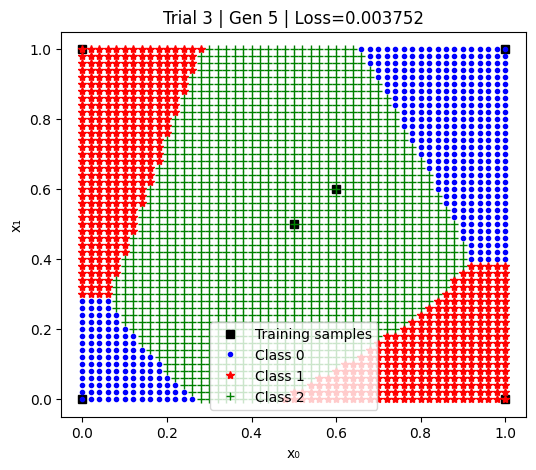

Class-0 (blue) % = 17.76
Class-1 (red)  % = 23.99
Class-2 (green)% = 58.25
Trial 3: Trial completed

System Success = 100.00%
Average # of generations used = 7


In [32]:
import numpy as np
from keras.models import save_model
import time


# constants
MaxGen   = 35    # generations per trial
MaxTrial = 3     # number of independent trials
numVar   = 6     # number of hyperparameters

# initial step size and adjustment ratio
stepSize_i = 0.82     # initial step size
stepSize_r = 0.82     # step size ratio (Rechenberg constant)

totgen  = 0
foundCnt = 0
objfunc = XOR3_eval   # link to objective function

print("[#neurons, lr, bsize, actfun, lossfun, optmzr]")

overall_start = time.time()

for trial in range(MaxTrial):
    trial_start = time.time()
    print(f"\n************************** Trial # = {trial+1} started at {format_time(trial_start)} **************************")
    print(f"Trial {trial+1}: Initializing hyperparameters")
    best_p_val = 9999.0
    xp = np.empty(numVar)  # parent
    xo = np.empty(numVar)  # offspring
    successCnt = 0
    WindowSize = 10
    stepSize = stepSize_i

    # --- initialize hyperparameters (start point) ---
    hparams = [
        (np.random.randint(2, 16), 2, 16),          # hidden neurons
        (round(np.random.uniform(0.01, 1.5), 2), 0.01, 1.5),  # learning rate
        (np.random.randint(1, 5), 1, 5),            # batch size
        (np.random.randint(0, len(act_func)), 0, len(act_func)-1),  # activation
        (np.random.randint(100, 501), 100, 500),                                  # loss fixed
        (np.random.randint(0, len(optimz)), 0, len(optimz)-1)       # optimizer
    ]

    for i in range(numVar):
        xp[i] = hparams[i][0]

    # evaluate parent
    print(f"Trial {trial+1}: Evaluating parent")
    p_val = objfunc(xp)
    print(f"Trial {trial+1}: Parent value: {p_val}")

    # --- evolution loop ---
    print(f"Trial {trial+1}: Starting evolution loop")
    for g in range(1, MaxGen + 1):
        print(f"Trial {trial+1}, Gen {g}: Starting generation")

        # 1/5 success rule step-size adaptation
        if (g % WindowSize) == 0:
            print(f"Trial {trial+1}, Gen {g}: Adapting step size")
            if successCnt > (WindowSize * 0.2):
                stepSize /= stepSize_r
            elif successCnt < (WindowSize * 0.2):
                stepSize *= stepSize_r
            successCnt = 0
            print(f"Trial {trial+1}, Gen {g}: New step size: {stepSize}")

        # mutate each hyperparameter with scaled step size
        print(f"Trial {trial+1}, Gen {g}: Mutating hyperparameters")
        for i in range(numVar):
            range_scale = hparams[i][2] - hparams[i][1]
            variation = np.random.normal(0.0, stepSize) * range_scale
            if i == 1:   # learning rate: keep decimals
                xo[i] = round(xp[i] + variation, 2)
            else:
                xo[i] = xp[i] + variation
            xo[i] = np.clip(xo[i], hparams[i][1], hparams[i][2])

        print(f"Trial {trial+1}, Gen {g}: Offspring: {xo}")

        # evaluate offspring
        print(f"Trial {trial+1}, Gen {g}: Evaluating offspring")
        o_val = objfunc(xo)
        print(f"Trial {trial+1}, Gen {g}: Offspring value: {o_val}")

        # selection
        if o_val < p_val:
            xp = xo.copy()
            p_val = o_val
            successCnt += 1
            print(f"Trial {trial+1}, Gen {g}: Offspring accepted, new parent value: {p_val}")
        else:
            print(f"Trial {trial+1}, Gen {g}: Offspring rejected")

        # check acceptable solution
        if p_val < 0.01:
            success_time = time.time()
            print(f"\nTrial {trial+1}: Acceptable solution found after {g} generations at {format_time(success_time)}")
            print_HP_found(xp, p_val)

            plot_XOR3_decision_boundary(model, title=f"Trial {trial+1} | Gen {g} | Loss={p_val:.6f}")

            if p_val < best_p_val:
                best_p_val = p_val
                save_model(model, "bestXOR.keras")
            totgen += g
            foundCnt += 1
            print(f"✅ Time taken for this success: {format_time(success_time - trial_start)}")
            break  # stop this trial early if success

    trial_end = time.time()
    print(f"⏱️ Trial {trial+1} completed in {format_time(trial_end - trial_start)}")

    # end of one trial
overall_end = time.time()
print(f"\n🏁 Total runtime for all trials: {format_time(overall_end - overall_start)}")
print(f"\nSystem Success = {foundCnt / MaxTrial * 100:.2f}%")
totgen += (MaxTrial - foundCnt) * MaxGen
print(f"Average # of generations used = {totgen / MaxTrial:.0f}")

xpoints: [0.  0.  1.  1.  0.5 0.6]
ypoints: [0.  1.  0.  1.  0.5 0.6]


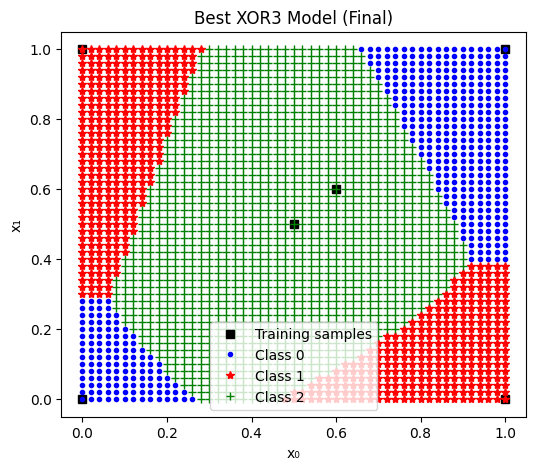

Class-0 (blue) % = 17.76
Class-1 (red)  % = 23.99
Class-2 (green)% = 58.25


In [33]:
plot_XOR3_decision_boundary(model_path="bestXOR.keras", title="Best XOR3 Model (Final)")

In [34]:
print (model.predict(X))
print (model.predict(X, verbose=0).round())
(loss, acc) = model.evaluate(Xt, yt)
print (f"loss = {loss}, acc = {acc}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
[[9.9985194e-01 6.4298452e-05 8.3767642e-05]
 [5.6403724e-06 9.9931479e-01 6.7962304e-04]
 [1.2410307e-04 9.9902773e-01 8.4819645e-04]
 [9.9346548e-01 1.0494902e-03 5.4849274e-03]
 [2.0531767e-04 4.7028801e-04 9.9932444e-01]
 [1.5622629e-03 1.0997187e-03 9.9733800e-01]]
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 0. 1.]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 1.0000 - loss: 0.0038
loss = 0.003752274438738823, acc = 1.0


In [35]:
# model save into a file and reloading the model
model.summary()
# model.save('xor3.keras') # the file is stored on the cloud account. Will stay a day

model.load_weights('bestXOR.keras')
print (model.predict(X))
print (model.predict(X, verbose=0).round())
model.evaluate(Xt, yt)

m2 = keras.models.load_model('bestXOR.keras')
m2.summary()
print (m2.predict(X))
print (m2.predict(X, verbose=0).round())
(loss, acc) = m2.evaluate(Xt, yt)
print (f"loss = {loss}, acc = {acc}")

Model: "sequential_129"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_258 (Dense)                    │ (None, 16)                  │              48 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_259 (Dense)                    │ (None, 3)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 299 (1.17 KB)

 Trainable params: 99 (396.00 B)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 200 (804.00 B)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
[[9.9985194e-01 6.4298452e-05 8.3767642e-05]
 [5.6403724e-06 9.9931479e-01 6.7962304e-04]
 [1.2410307e-04 9.9902773e-01 8.4819645e-04]
 [9.9346548e-01 1.0494902e-03 5.4849274e-03]
 [2.0531767e-04 4.7028801e-04 9.9932444e-01]
 [1.5622629e-03 1.0997187e-03 9.9733800e-01]]
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 0. 1.]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 1.0000 - loss: 0.0038


Model: "sequential_129"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_258 (Dense)                    │ (None, 16)                  │              48 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_259 (Dense)                    │ (None, 3)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 299 (1.17 KB)

 Trainable params: 99 (396.00 B)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 200 (804.00 B)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
[[9.9985194e-01 6.4298452e-05 8.3767642e-05]
 [5.6403724e-06 9.9931479e-01 6.7962304e-04]
 [1.2410307e-04 9.9902773e-01 8.4819645e-04]
 [9.9346548e-01 1.0494902e-03 5.4849274e-03]
 [2.0531767e-04 4.7028801e-04 9.9932444e-01]
 [1.5622629e-03 1.0997187e-03 9.9733800e-01]]
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 0. 1.]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 293ms/step - accuracy: 1.0000 - loss: 0.0038
loss = 0.003752274438738823, acc = 1.0


In [36]:
# # Using 'categorical_crossentropy'

# model = Sequential([
#     keras.Input(shape=(2,)),
#     Dense(16, activation='relu'),
#     Dense(3, activation='softmax')
# ])
# model.compile(
#   optimizer='rmsprop',
#   loss='categorical_crossentropy', # target labels are 1hot encoded format
#   metrics=['accuracy']
# )

# # Converting y to one-hot encoded format with shape (5,3)
# y_1hot = keras.utils.to_categorical(y, num_classes=3)
# model.fit(X, y_1hot, batch_size=1, epochs=1300, verbose=0)
# print (model.predict(X))
# print (model.predict(X, verbose=0).round())
# yt_1hot = keras.utils.to_categorical(yt, num_classes=3)
# model.evaluate(Xt, yt_1hot)